### 사용할 PDF 파일 확인하기

In [2]:
from glob import glob
for g in glob('./data/*.pdf'):
    print(g)

./data\2040_seoul_plan.pdf
./data\OneNYC-2050-Summary.pdf


### read_pdf_and_split_text 함수 만들기

In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    매개변수:
        pdf_path (str): PDF 파일의 경로
        chunk_size (int, 선택적): 각 텍스트 청크의 크기. 기본값은 1000입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기. 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트.
    """
    print(f"PDF: {pdf_path} -------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)

    print(f"Number of splits: {len(splits)}\n")
    return splits

### vectorstore 설정하고 청크 처리하기

In [9]:
import os
import dotenv
from langchain_community.vectorstores import FAISS

dotenv.load_dotenv()

# embedding 설정 추가
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(
    model='text-embedding-3-large',
    api_key=os.getenv('OPENAI_API_KEY')
)

# vectorstore 설정
if os.path.exists('./chroma_store'):
    print("Loading existing FAISS store")
    vectorstore = FAISS.load_local(
        './chroma_store',
        embedding
    )
else:
    print("Creating new FAISS store")
    
    vectorstore = None
    for g in glob('./data/*.pdf'):
        chunks = read_pdf_and_split_text(g)
        # 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = FAISS.from_documents(
                    documents=chunks[i:i+100],
                    embedding=embedding
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100]
                )
    
    # FAISS 저장
    vectorstore.save_local('./chroma_store')

Creating new FAISS store
PDF: ./data\2040_seoul_plan.pdf -------------
Number of splits: 266

PDF: ./data\OneNYC-2050-Summary.pdf -------------
Number of splits: 176



### 관련 문서 검색하기

In [10]:
retriever = vectorstore.as_retriever(search_kwargs={'k': 5})

chunks = retriever.invoke("서울 온실가스 저감 계획")

for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)

{'producer': 'Hancom PDF 1.3.0.542', 'creator': 'Hwp 2020 11.0.0.4643', 'creationdate': '2023-01-04T20:47:24+09:00', 'author': 'SI', 'moddate': '2023-01-04T20:47:24+09:00', 'pdfversion': '1.4', 'source': './data\\2040_seoul_plan.pdf', 'total_pages': 195, 'page': 63, 'page_label': '64'}
64제2장 미래상과 목표6. 미래위기를 준비하는, ‘탄소중립 안전도시 구축’1) 배경전(全) 지구적인 기후변화에 대응하기 위한 대도시 차원의 대응 필요Ÿ서울시 2017년 온실가스 배출량은 46,685천 톤CO2eq로 2005년 배출량에 비해 5.6%(276만 톤CO2eq) 감소하였으며, 서울의 1인당 온실가스 배출량은 4.7CO2eq/인으로 국가의 13.8 톤CO2eq/인에 비해 낮은 수준이다. 또한 2014년 기준 서울의 1인당 온실가스 배출량은 4.5CO2eq/인으로 세계 주요 도시에 비해 낮은 수준을 보인다7).
<그림 2-26> 세계 주요 도시 1인당 온실가스 배출량자료: World Bank, 2014Ÿ그럼에도 불구하고, 기후변화 문제는 21세기에 전(全)지구적으로 가장 위중한 영향을 미칠 것으로 예상되는 바, 탄소중립과 기후위기 대응은 국제·국가·도시의 핵심 정책으로 다루어져야 한다.Ÿ파리협정(2015) 이후, 우리나라를 비롯한 미국, 유럽연합 등 세계 136개국이 탄소중립을 선언하였으며, 서울시를 비롯한 뉴욕, 런던 등과 같은 많은 글로벌 도시에서 탄소중립을 시정의 핵심과제로 추진중이다.Ÿ우리나라는 2020년 ‘한국판 그린뉴딜’을 발표하며 공식적으로 2050 탄소중립을 선언하였으며 서울시 역시 2020년 ‘그린뉴딜 추진을 통한 2050 온실가스 감축 전략’을 발표하고 탄소중립을 선언에 따른 부문별 사업을 적극 추진하고 있다.-서울시는 2050년 

### 언어 모델 설정하기

In [11]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model = 'gpt-4o-mini')
model.invoke("안녕하세요")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d77b305a29', 'id': 'chatcmpl-CBcIjV9aTuJ0oRn1RVOeNs2rA2i3y', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d46fc43e-6c11-46d9-be1c-63b24bd86f1b-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### 라우터 설정하기

In [13]:
# 라우터 설정
from typing import Literal
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅 합니다."""

    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore로 라우팅합니다.
        - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

### 사용자 질문 받고 판단하기

In [18]:
from langchain_core.prompts import ChatPromptTemplate

# 특정 모델을 structured output(구조화된 출력)과 함께 사용하기 위해 설정
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}")
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_router = router_prompt | structured_llm_router

### 결과 출력하기

In [19]:
print(
    question_router.invoke({
        "question": "서울 온실가스 저감 계획은 무엇인가요?"
    })
)

print(question_router.invoke({"question": "오늘 날씨가 어때?"}))

datasource='vectorstore'
datasource='casual_talk'


### GradeDocuments 클래스 만들기

In [20]:
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다."
    )

structured_llm_grader = model.with_structured_output(GradeDocuments)

### 프롬프트 작성하고 테스트하기

In [21]:
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.

Retrieved document: \n {document} \n\n
User question: {question} 
""")

retrieval_grader = grader_prompt | structured_llm_grader
question = "서울시 자율주행 관련 계획"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)

page_content='62제2장 미래상과 목표5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래 교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구축을 준비해야 한다.미래교통수단 정착을 위한 도시 인프라 확충지원 필요Ÿ기존에 없던 새로운 교통은, 통상 인프라 구축에 많은 시간이 소요되기 때문에 교통수단 도입이 된 다음 준비하기보다는 개발단계에서부터 이를 지원하기 위한 교통인프라 구축 구상이 요구되며, 새로운 도시 인프라 확충에 대한 도시계획적 지원이 필요하다.2) 추진전략자율주행 자동차 본격 운영 체계 구축Ÿ자율주행은 현재 제일 가시화되고 있는 미래 교통기술로 시장의 주도권을 확보하기 위해 각국의 노력이 집중되고 있다. 단계적으로 2030년까지 간선도로급 이상 도로에서 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역 자율주행 운행 환경 구축을 목표로 한다.-2040년까지 서울 전역 자율주행차량의 운행 환경을 구축하고 수송 분담률 10%를 달성서울형 도심 항공교통 기반 마련 및 터미널 확충Ÿ도심에서 김포공항까지 시범노선을 운영하는 등 상용화 노선을 확보하고, 장기적으로 한강, 지천 등 주요 수변 공간 중심으로 광역노선을 확보한다. 또한 UAM 인프라 확보를 위한 인센티브 및 도시계획적인 지원 방안도 함께 검토한다.-UAM 시범노선을 운영하고, 한강 등 주요 수변 공간 중심에 단계적 광역노선을 확장서울 전역에 모빌리티 허브 구축Ÿ도심 및 광역거점에서는 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입한다. 또한 교통뿐 아니라 공공서비스, 물류, 상업 등 다양한 기능들이 복합적으로 제공되는 지역 거점 모빌리티 허브를 서울 전역에 도입한다.' metadata={'producer': '

### 관련된 청크만 리스트에 추가하기

In [22]:
filtered_docs = []

for i, doc in enumerate(documents):
    print(f"Document {i+1}:")
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("==============================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)

print(f"Filtered documents: {len(filtered_docs)}")

Document 1:
binary_score='yes'
62제2장 미래상과 목표5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래 교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구


Document 2:
binary_score='yes'
98제3장 부문별 전략계획5-1 미래교통수단과 융합을 위한 선제적 교통환경 구축5-1-1 신 교통수단·기술발전 등 미래 환경 변화에 대비한 인프라 구축·정비ŸUAM·전기차·자율주행차 등 미래교통수단의 상용화에 대비하여 첨단 기반시설과 빅데이터 플랫폼 등을 확충한다.-자율주행차의 시범 운영지역의 확대, 지역 거점별 특성에 맞는 다양한 서비스 구현, 서울 전역


Document 3:
binary_score='no'
명확히 설정하고, 2040 서울도시기본계획에서 새롭게 제시하는 공간구조인 보행일상권을 실현하기 12) 맹다미 외, 2022, 미래 여건변화에 대응하는 도시계획체계 개편방안 연구, 서울연구원


Document 4:
binary_score='yes'
44제2장 미래상과 목표Ÿ심화되는 글로벌 도시경쟁에 대응하여 서울의 미래 경쟁력을 확보하기 위해 지속가능한 산업 정책과 도시공간 구조의 개편이 필요하다.6) 미래교통수단의 등장과 첨단 인프라 요구 증대자율주행, UAM 등 미래 교통에 공간적 대응방안 마련 필요Ÿ자율주행차량, 전동킥보드 등 교통 기술의 발전에 따라 새로운 교통환경이 조성되고 있음에도 불구하고


Document 5:
binary_score='yes'
2040 서울도시기본계획 보고서2022


Filtered documents: 4


### RAG를 위한 프롬프트 생성하기

In [23]:
### Generate
# PromptTemplate을 사용해 RAG를 위한 프롬프트 생성

rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다.
주어진 context는 vectorstore에서 검색된 결과이다.
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=============================
question: {question}
context: {context}
"""

# PromptTemplate을 생성해 question과 context를 포매팅
rag_prompt = PromptTemplate(
    input_variables = ["question", "context"],
    template=rag_generate_system
)

# rag chain
rag_chain = rag_prompt | model

# 사용자의 질문과 검색된 문서를 입력으로 사용해 RAG를 실행
question = "서울시 자율주행 관련 계획"

rag_chain.invoke({"question": question, "context": filtered_docs})

AIMessage(content='서울시 자율주행 관련 계획은 2030년까지 자율주행 자동차의 본격 운영 체계를 구축하고, 2040년까지 서울 전역에서 자율주행 차의 운행 환경을 구축하는 것을 목표로 하고 있습니다. 구체적으로, 간선도로급 이상의 도로에서 자율주행을 운영할 수 있는 인프라 환경을 구축하며, 자율주행 차량의 수송 분담률을 10% 달성하는 것을 주요 목표로 하고 있습니다.\n\n또한, 서울시는 도심 항공교통(UAM)의 기반 마련 및 터미널 확충을 통해 도심과 김포공항을 연결하는 시범 노선을 운영하고, 장기적으로는 주요 수변 공간을 중심으로 광역노선을 확보하는 방향으로 나아가고 있습니다. 이를 위해 서울 전역에 모빌리티 허브를 구축하여 다양한 교통수단 간의 연계를 지원하고, 공공 서비스, 물류, 상업 등 다양한 기능이 결합된 지역 거점을 마련할 계획입니다.\n\n서울시는 이러한 자율주행 및 교통 인프라 구축을 위해 스마트 도로 인프라와 빅데이터 플랫폼 등을 확충하고, 교통수단 간의 편리한 환승을 지원하기 위한 통합 모빌리티 플랫폼 개발도 지속적으로 추진할 예정입니다. 이를 통해 심화되는 도시 교통 문제를 해결하고, 미래 교통환경 변화에 적절하게 대응할 수 있는 기반을 마련하고자 합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 323, 'prompt_tokens': 2389, 'total_tokens': 2712, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini

## 그래프 정의하기
### 그래프 상태 선언하기

In [24]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

### route_question 함수 만들기

In [25]:
def route_question(state):
    """
    사용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.

    Args:
        state (dict): 현재 graph state
    
    return:
        state (dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----------ROUTE----------')
    question = state['question']
    route = question_router.invoke({"question": question})

    print(f"----Routing to {route.datasource}----")
    return route.datasource

### retrieve 노드 정의하기

In [26]:
def retrieve(state):
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----------RETRIEVE----------')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

### grade_documents 노드 정의하기

In [27]:
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지를 확인합니다.

    Args:
        state (dict): 현재 graph state
    
    return:
        state (dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----------GRADE----------')
    question = state['question']
    documents = state['documents']
    filtered_docs = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
    return {"documents": filtered_docs, "question": question}

### generate 노드 정의하기

In [28]:
def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state
    
    return:
        state (dict): LLM 생성 결과와 사용자 질문을 포함한느 새로운 graph state
    """
    print('-----------GENERATE----------')
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

### casual_talk 노드 정의하기

In [29]:
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state
    
    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----------CASUAL TALK----------')
    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

### StateGraph 객체 생성하기

In [31]:
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

### 노드 등록하고 연결하기

In [32]:
# 노드를 정의
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

### 그래프 정의하기

In [33]:
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)
workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

### 그래프 출력하기

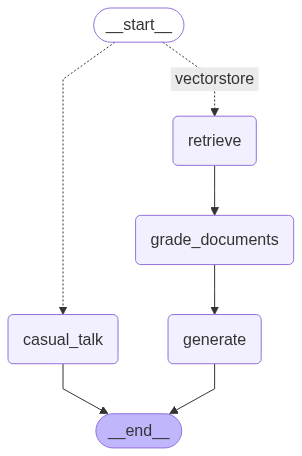

In [34]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 멀티 에이전트에게 질문하기

In [35]:
inputs = {
    "question": "서울시 자율주행 계획"
}

app.invoke(inputs)

-----------ROUTE----------
----Routing to vectorstore----
-----------RETRIEVE----------
-----------GRADE----------
-----------GENERATE----------


{'question': '서울시 자율주행 계획',
 'generation': AIMessage(content='서울시는 자율주행 자동차와 관련하여 미래 교통 기술의 선도적 도입을 목표로 하고 있습니다. 2030년까지 간선도로급 이상에서 자율주행차량을 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역에 자율주행 운행 환경을 구축하는 것이 주요 목표입니다. 이 과정에서 수송 분담률 10%를 달성하는 것도 계획하고 있습니다.\n\n자율주행차를 포함한 미래 교통수단의 상용화를 위해, 첨단 기반시설과 빅데이터 플랫폼을 확대하고 도로 정밀지도와 교통 데이터를 갖춘 스마트 도로 인프라 구축을 지속적으로 추진할 예정입니다. 또한, 서울 전역에 모빌리티 허브를 구축하여 다양한 교통 수단 간의 원활한 환승을 지원하고, 관련 서비스와 기능이 통합된 공간으로 발전시킬 계획입니다.\n\n이와 더불어 혁신적인 교통 인프라 구축을 통해 UAM(도심 항공 모빌리티) 및 개인형 이동장치와 같은 새로운 교통 수단과의 연계도 고려하고 있습니다. 이는 미래 도시 환경에서의 사람들의 이동 방식을 변화시키고 도시 공간의 효율성을 높이는 데 기여할 것으로 예상됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 289, 'prompt_tokens': 2290, 'total_tokens': 2579, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_finger

### 워크플로 확인하기

In [36]:
inputs = {
    "question": "잘 지내고 있어?"
}

app.invoke(inputs)

-----------ROUTE----------
----Routing to casual_talk----
-----------CASUAL TALK----------


{'question': '잘 지내고 있어?',
 'generation': AIMessage(content='네, 잘 지내고 있습니다! 당신은 어떻게 지내세요? 궁금한 점이나 이야기하고 싶은 주제가 있으면 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 13, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBd4Yx0wTZRyWKJkL1RCp51fjBgEx', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1539f0df-27c4-4b49-8a15-880a9fbb4309-0', usage_metadata={'input_tokens': 13, 'output_tokens': 31, 'total_tokens': 44, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

### 스트림 방식으로 출력하기

In [37]:
inputs = {
    "question": "서울시 자율주행 차량 계획은 무엇이 있나요?"
}

for msg, meta in app.stream(inputs, stream_mode="messages"):
    print(msg.content, end="")

-----------ROUTE----------
{"datasource":"vectorstore"}----Routing to vectorstore----
-----------RETRIEVE----------
-----------GRADE----------
{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"yes"}-----------GENERATE----------
서울시의 자율주행 차량 계획은 다음과 같습니다:

1. **운영 체계 구축**: 서울시는 자율주행 차량을 본격적으로 운영할 수 있는 체계를 2030년까지 간선도로급 이상 도로에서 구축할 계획입니다. 최종 목표는 2040년까지 서울 전역에서 자율주행 차가 운행될 수 있는 환경을 조성하는 것입니다. 자율주행차의 수송 분담률 10%를 달성하는 것을 목표로 하고 있습니다.

2. **인프라 확충**: 자율주행차의 도입에 대비하여 도시 내 다양한 통행행태가 공존할 수 있는 포용적인 교통체계 구축이 필요합니다. 이를 위해 새로운 교통수단에 맞는 인프라를 개발 단계부터 계획하고 지원해야 합니다.

3. **스마트 도로 인프라**: 자율주행차의 시범 운영지역을 확대하고, 서울 전역을 연결하는 자율주행 버스 노선을 설계하는 것을 포함하여, 도로 정밀지도와 교통 데이터 등을 갖춘 스마트 도로 인프라를 단계적으로 확립할 계획입니다.

4. **모빌리티 허브 구축**: 도심 및 광역거점에서 미래 교통과 기존 교통을 연결하는 시설을 도입하여 서울 전역에 다양한 기능을 갖춘 모빌리티 허브를 구축할 예정입니다.

이러한 계획은 자율주행차를 포함한 새로운 교통수단의 안전하고 효율적인 정착을 위한 기반을 마련하기 위한 것입니다.